#Introduction to Memory Profiling

> Objectives:
> * Be introduced to memory profiling using different tools
> * Some small introduction to time profiling in IPython too


##ipython_memwatcher

Our recommended way to profile memory consumption for this tutorial will be [ipython_memwatcher](https://pypi.python.org/pypi/ipython_memwatcher):


In [1]:
from ipython_memwatcher import MemWatcher
mw = MemWatcher()
mw.start_watching_memory()

In [1] used 0.035 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 28.773 MiB


In [2]:
# Let's create a big object
a = [i for i in range(1000*1000)]

In [2] used 33.234 MiB RAM in 0.142s, peaked 7.324 MiB above current, total RAM usage 62.008 MiB


In [3]:
# Get some measurements from the last executed cell:
meas = mw.measurements
meas

Measurements(memory_delta=33.234375, time_delta=0.1421198844909668, memory_peak=7.32421875, memory_usage=62.0078125)

In [3] used -1.949 MiB RAM in 0.021s, peaked 0.000 MiB above current, total RAM usage 60.059 MiB


In [4]:
# MemWatcher.measurements is a named tuple.  We can easily get info out of it:
meas.memory_delta

33.234375

In [4] used 0.016 MiB RAM in 0.006s, peaked 0.000 MiB above current, total RAM usage 60.074 MiB


In [5]:
# This takes betweed 32 ~ 35 bytes per element:
meas.memory_delta * (2**20) / 1e6

34.848768

In [5] used 0.004 MiB RAM in 0.005s, peaked 0.000 MiB above current, total RAM usage 60.078 MiB


In [6]:
# What are these elements made from?
type(a[0])

int

In [6] used 0.000 MiB RAM in 0.006s, peaked 0.000 MiB above current, total RAM usage 60.078 MiB


In [7]:
# How much memory take an int?
# Beware: the size below will depend on whether you are using a 32-bit or 64-bit Python
import sys
sys.getsizeof(a[0])

24

In [7] used 0.004 MiB RAM in 0.006s, peaked 0.000 MiB above current, total RAM usage 60.082 MiB


Ok.  On 64-bits, that means that the int object allocates 8 bytes for the integer value, and 16 bytes for other metadata (Python object).  But 24 is quite less than 32~35.  Where this overhead comes from?

##objgraph

Graph written to /tmp/objgraph-gLJZaX.dot (4 nodes)
Image generated as simple-list.png


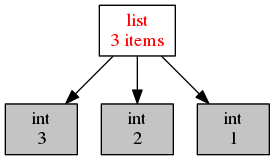

In [8] used 0.066 MiB RAM in 0.094s, peaked 0.000 MiB above current, total RAM usage 60.148 MiB


In [8]:
# Let's introduce the objgraph package and see
b = [1,2,3]
import objgraph
objgraph.show_refs([b], filename='simple-list.png')
from IPython.core.display import Image 
Image('simple-list.png')

So, the list is an structure that takes a pointer (8 bytes in 64-bit platforms) per every element in the list.  If we add this to the 24 bytes per int, then we have 32 bytes per element, which is close to the computed 32~35 bytes above.  The remaining difference is probably due to how Python handles memory internally (over-allocation). 

##memory_profiler

[memory_profiler](https://pypi.python.org/pypi/memory_profiler) is a basic module for memory profiling that many others use (like the `ipython_memwatcher` above) and it interacts well with ipython, so it is worth to see how it works:

In [9]:
%load_ext memory_profiler

In [9] used 0.113 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 60.262 MiB


In [10]:
# Use %memit magic command exposed by memory_profiler
%memit b = [i for i in range(1000*1000)]

peak memory: 132.43 MiB, increment: 72.16 MiB
In [10] used 72.164 MiB RAM in 0.435s, peaked 0.000 MiB above current, total RAM usage 132.426 MiB


Please note that the `peak_memory` in this case is different than the `peaked_memory` reported by ipython_memwatcher package.

##Guppy

Guppy is nice for having an overview of how different structures are using our memory:

In [11]:
from guppy import hpy; hp=hpy()
hp.heap()

Partition of a set of 2128439 objects. Total size = 81725384 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0 2004742  94 48113808  59  48113808  59 int
     1   1180   0 16434528  20  64548336  79 list
     2  57604   3  5178288   6  69726624  85 str
     3  30885   1  2677600   3  72404224  89 tuple
     4   1745   0  1713944   2  74118168  91 dict (no owner)
     5    436   0  1256416   2  75374584  92 dict of module
     6   7828   0  1001984   1  76376568  93 types.CodeType
     7   7722   0   926640   1  77303208  95 function
     8    943   0   849784   1  78152992  96 type
     9    943   0   779752   1  78932744  97 dict of type
<562 more rows. Type e.g. '_.more' to view.>

In [11] used 31.668 MiB RAM in 3.135s, peaked 0.000 MiB above current, total RAM usage 164.094 MiB


In [12]:
del b
hp.heap()

Partition of a set of 1128716 objects. Total size = 49609424 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0 1005000  89 24120000  49  24120000  49 int
     1   1177   0  8307848  17  32427848  65 list
     2  57609   5  5178584  10  37606432  76 str
     3  30885   3  2677624   5  40284056  81 tuple
     4   1751   0  1715624   3  41999680  85 dict (no owner)
     5    436   0  1256416   3  43256096  87 dict of module
     6   7828   1  1001984   2  44258080  89 types.CodeType
     7   7721   1   926520   2  45184600  91 function
     8    943   0   849784   2  46034384  93 type
     9    943   0   779752   2  46814136  94 dict of type
<558 more rows. Type e.g. '_.more' to view.>

In [12] used 37.398 MiB RAM in 0.766s, peaked 0.000 MiB above current, total RAM usage 201.492 MiB


In [13]:
# Size of the list (beware, this does not include the contents!)
hp.iso(a)

Partition of a set of 1 object. Total size = 8126536 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0      1 100  8126536 100   8126536 100 list

In [13] used 0.023 MiB RAM in 0.009s, peaked 0.000 MiB above current, total RAM usage 201.516 MiB


##%time and %timeit

In [14]:
# IPython provides a magic command to see how much time a command takes to run
%time asum = sum(a)

CPU times: user 18.5 ms, sys: 264 µs, total: 18.8 ms
Wall time: 22 ms
In [14] used 0.016 MiB RAM in 0.027s, peaked 0.000 MiB above current, total RAM usage 201.531 MiB


Note that `%time` offers quite detailed statistics on the time spent.

Also, the time reported by MemoryWatcher has a typical overhead of 3~10 ms over the time reported by %time, so when the times to measure are about this order then it is better to rely on the %time (or %timeit below) values.  

In [15]:
# We have another way to measure timings doing several loops and getting the mean
%timeit bsum = sum(a)

100 loops, best of 3: 6.95 ms per loop
In [15] used 0.020 MiB RAM in 2.970s, peaked 0.000 MiB above current, total RAM usage 201.551 MiB


In [16]:
# However, one must notice that %timeit does not return the result of expressions
bsum

NameError: name 'bsum' is not defined

In [16] used 0.742 MiB RAM in 0.089s, peaked 0.000 MiB above current, total RAM usage 202.293 MiB


Interestingly, %timeit allows to retrieve the measured times in loops with the -o flag:

In [17]:
t = %timeit -o sum(a)
print(t.all_runs)
print(t.best)

100 loops, best of 3: 6.94 ms per loop
[0.7002749443054199, 0.6935679912567139, 0.6935369968414307]
0.00693536996841
In [17] used 0.000 MiB RAM in 2.948s, peaked 0.000 MiB above current, total RAM usage 202.293 MiB


And one can specify the number of loops (-n) and the number of repetitions (-r):

In [18]:
t = %timeit -r1 -n1 -o sum(a)
print(t.all_runs)
print(t.best)

1 loops, best of 1: 17.6 ms per loop
[0.017561912536621094]
0.0175619125366
In [18] used 0.000 MiB RAM in 0.024s, peaked 0.000 MiB above current, total RAM usage 202.293 MiB


### Exercise 1

Provided a dictionary like:

```
d = dict(("key: %i"%i, i*2) for i in a)
```

Try to guess how much RAM it uses using the techniques introduced above.

Why do you think it takes more space than a list?

*Hint*: Use the `objgraph` package on a short dictionary so as to better see the data structure.  In case you cannot get `objgraph` to work, every entry in a dictionary has pointers to two objects: key and value. 

##Solution

In [19]:
d = dict(("key: %i"%i, i*2) for i in a)

In [19] used 94.137 MiB RAM in 0.967s, peaked 0.000 MiB above current, total RAM usage 296.430 MiB


Graph written to /tmp/objgraph-gnyjwx.dot (11 nodes)
Image generated as dict.png


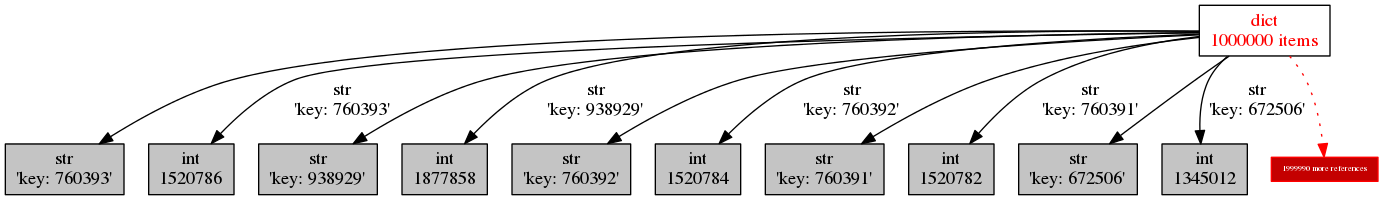

In [22] used 0.000 MiB RAM in 1.473s, peaked 0.004 MiB above current, total RAM usage 296.828 MiB


In [22]:
objgraph.show_refs([d], filename='dict.png')
from IPython.core.display import Image 
Image('dict.png')

In [36]:
# Compute the size of key + value
sys.getsizeof("key: 100000") + sys.getsizeof(1)

72

In [36] used 0.000 MiB RAM in 0.006s, peaked 0.000 MiB above current, total RAM usage 296.836 MiB


In [38]:
# Compute the size of a key + value + pointers for all elements in MB
(sys.getsizeof("key: 100000") + sys.getsizeof(1) + 16) * 1000*1000 / 2**20.

83.92333984375

In [38] used 0.000 MiB RAM in 0.008s, peaked 0.000 MiB above current, total RAM usage 296.836 MiB


In [33]:
# Using guppy
hp.iso(d)

Partition of a set of 1 object. Total size = 50331928 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0      1 100 50331928 100  50331928 100 dict (no owner)

In [33] used 0.000 MiB RAM in 0.689s, peaked 0.000 MiB above current, total RAM usage 296.836 MiB


So, guppy is telling us that just the dictionary structure is taking ~50 MB, whereas the contents alone are taking ~70MB, so we should have expected the dictionary to consume ~120 MB.  However, our `MemWatcher` instance is reporting just 94 MB.  Take away lesson: measuring memory consumption in Python is tricky but using proper tools we can still have valuable hints!